In [1]:
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt

#### 1. Load train, test and validation data

In [2]:
from utils.ecg_processing import EcgSignalProcessor

In [3]:
ecg_processor = EcgSignalProcessor(
    data_path='data/autonomic-aging-cardiovascular/1.0.0', 
    templates_to_extract=100,
)

In [ ]:
X_train, y_train = ecg_processor.read_ecg_dataset(start_idx=0, end_idx=60)
X_val, y_val = ecg_processor.read_ecg_dataset(start_idx=600, end_idx=620)
X_test, y_test = ecg_processor.read_ecg_dataset(start_idx=800, end_idx=820)

In [16]:
# with open('training_data/autoencoder_data.pkl', 'wb') as f:
#     pickle.dump({
#         'X_train': X_train,
#         'X_test': X_test,
#         'X_val': X_val,
#         'y_train': y_train,
#         'y_test': y_test,
#         'y_val': y_val
#     }, f)

In [26]:
with open('training_data/autoencoder_data.pkl', 'rb') as f:
    data = pickle.load(f)

X_train = np.array(data['X_train'])
X_test = np.array(data['X_test'])
X_val = np.array(data['X_val'])

In [27]:
y_test = set(data['y_test'])
y_train = set(data['y_train'])
y_val = set(data['y_val'])

#### 2. Define the autoencoder model

In [16]:
from keras.optimizers import Adam
from keras.models import Model, clone_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Reshape, Conv1D, BatchNormalization, ReLU, UpSampling1D, Dense, Flatten, Concatenate, MaxPooling1D

2024-07-10 11:42:23.634855: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-10 11:42:29.737430: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-10 11:42:43.635155: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [17]:
input_dim = 600
input_signal = Input(shape=(input_dim,), name='encoder_input')
encoder_input = Reshape((input_dim, 1))(input_signal)

layer_1 = Conv1D(8, kernel_size=1, padding='same')(encoder_input)
layer_1 = BatchNormalization()(layer_1)
layer_1 = ReLU()(layer_1)
layer_1 = MaxPooling1D(pool_size=3)(layer_1)

layer_2 = Conv1D(16, kernel_size=1, padding='same')(layer_1)
layer_2 = BatchNormalization()(layer_2)
layer_2 = ReLU()(layer_2)
layer_2 = MaxPooling1D(pool_size=2)(layer_2)

layer_3 = Conv1D(32, kernel_size=1, padding='same')(layer_2)
layer_3 = BatchNormalization()(layer_3)
layer_3 = ReLU()(layer_3)
layer_3 = MaxPooling1D(pool_size=2)(layer_3)

layer_4 = Conv1D(32, kernel_size=1, padding='same')(layer_3)
layer_4 = BatchNormalization()(layer_4)
layer_4 = ReLU()(layer_4)
layer_4 = MaxPooling1D(pool_size=2)(layer_4)

layer_5 = Conv1D(1, kernel_size=1, padding='same')(layer_4)
layer_5 = Flatten()(layer_5)

2024-07-10 11:42:59.366894: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-10 11:42:59.482993: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-10 11:42:59.487178: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [18]:
encoder = Model(input_signal, layer_5, name='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 600, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 600, 8)         │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 600, 8)         │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 600, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 200, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 200, 16)        │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 200, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 200, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 100, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 100, 32)        │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 100, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 50, 32)         │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 50, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 25, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 25, 1)          │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,145 (8.38 KB)

 Trainable params: 1,969 (7.69 KB)

 Non-trainable params: 176 (704.00 B)

In [19]:
latent_sample = Input(shape=(25,))
decoder_input = Reshape((25, 1))(latent_sample)

layer_1 = Conv1D(32, kernel_size=1)(decoder_input)
layer_1 = BatchNormalization()(layer_1)
layer_1 = ReLU()(layer_1)
layer_1 = UpSampling1D(size=2)(layer_1)

layer_2 = Conv1D(32, kernel_size=3, padding='same')(layer_1)
layer_2 = BatchNormalization()(layer_2)
layer_2 = ReLU()(layer_2)
layer_2 = UpSampling1D(size=2)(layer_2)

layer_3 = Conv1D(16, kernel_size=3, padding='same')(layer_2)
layer_3 = BatchNormalization()(layer_3)
layer_3 = ReLU()(layer_3)
layer_3 = UpSampling1D(size=2)(layer_3)

layer_4 = Conv1D(8, kernel_size=3, padding='same')(layer_3)
layer_4 = BatchNormalization()(layer_4)
layer_4 = ReLU()(layer_4)
layer_4 = UpSampling1D(size=3)(layer_4)

layer_5 = Conv1D(1, kernel_size=3, padding='same')(layer_4)
layer_5 = Flatten()(layer_5)

In [20]:
decoder = Model(latent_sample, layer_5, name='decoder')
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 25, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 25, 32)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 25, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 25, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 50, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 50, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 100, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 100, 16)        │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 100, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 100, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_2 (UpSampling1D)  │ (None, 200, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 200, 8)         │           392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 200, 8)         │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 200, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_3 (UpSampling1D)  │ (None, 600, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 600, 1)         │            25 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 600)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,489 (21.44 KB)

 Trainable params: 5,313 (20.75 KB)

 Non-trainable params: 176 (704.00 B)

In [21]:
autoencoder = Model(
    input_signal, 
    decoder(encoder(input_signal)), 
    name='autoencoder'
)

In [22]:
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 25)             │         2,145 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 600)            │         5,489 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,634 (29.82 KB)

 Trainable params: 7,282 (28.45 KB)

 Non-trainable params: 352 (1.38 KB)

In [14]:
autoencoder.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='mse'
)

In [15]:
history = autoencoder.fit(
    X_train, X_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, X_val),
    callbacks=[
        EarlyStopping(patience=10)
    ]
)

Epoch 1/100


I0000 00:00:1720539922.931039 1980130 service.cc:145] XLA service 0x7f6184030ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720539922.931066 1980130 service.cc:153]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2024-07-09 16:45:22.994463: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-09 16:45:23.277147: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  74/1816 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.4483  

I0000 00:00:1720539925.584284 1980130 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1816/1816 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.2756 - val_loss: 0.0052
Epoch 2/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 3/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 4/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 5/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 6/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 9.2504e-04 - val_loss: 8.2056e-04
Epoch 7/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 7.5442e-04 - val_loss: 7.6631e-04
Epoch 8/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 6.7451e-04 - val_loss: 8.1177e-04
Epoch 9/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 6.0552e-04 - val_loss: 6.0884e-04
Epoch 10/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 5.6469e-04 - val_loss: 5.6583e-04
Epoch 11/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 5.2455e-04 - val

#### 3. Hyperparameter optimisation

In [16]:
epochs = 100
batch_sizes = [32, 64, 128, 256]
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2]

In [17]:
history_arr = []
batch_size = 32
for learning_rate in learning_rates:
    history_dict = {
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'history': []
    }
    for _ in range(5):
        tmp_model = clone_model(autoencoder)
        tmp_model.compile(
            optimizer=Adam(learning_rate=learning_rate), 
            loss='mean_squared_error'
        )
        history = tmp_model.fit(
            X_train, X_train,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=False,
            validation_data=(X_val, X_val)
        )
        history_dict['history'].append(history.history)
    history_arr.append(history_dict)

Epoch 1/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.5165 - val_loss: 0.1221
Epoch 2/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0956 - val_loss: 0.0375
Epoch 3/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0409 - val_loss: 0.0216
Epoch 4/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0269 - val_loss: 0.0150
Epoch 5/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0210 - val_loss: 0.0118
Epoch 6/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0178 - val_loss: 0.0100
Epoch 7/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0156 - val_loss: 0.0090
Epoch 8/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0138 - val_loss: 0.0084
Epoch 9/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0124 - val_loss: 0.0074
Epoch 10/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0109 - val_loss: 0.0067
Epoch 11/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0097 - val_loss: 0.0063
Epoch 12/100
1816/1

In [18]:
import json
with open('experiments/autoencoder_conv_history_lr.json', 'w') as f:
    json.dump(history_arr, f)

In [19]:
history_arr = []
learning_rate = 1e-4
for batch_size in batch_sizes:
    history_dict = {
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'history': []
    }
    for _ in range(5):
        tmp_model = clone_model(autoencoder)
        tmp_model.compile(
            optimizer=Adam(learning_rate=learning_rate), 
            loss='mean_squared_error'
        )
        history = tmp_model.fit(
            X_train, X_train,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=False,
            validation_data=(X_val, X_val)
        )
        history_dict['history'].append(history.history)
    history_arr.append(history_dict)

Epoch 1/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0937 - val_loss: 0.0125
Epoch 2/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0129 - val_loss: 0.0086
Epoch 3/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0088 - val_loss: 0.0069
Epoch 4/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0067 - val_loss: 0.0064
Epoch 5/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0058 - val_loss: 0.0060
Epoch 6/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0049 - val_loss: 0.0057
Epoch 7/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0043 - val_loss: 0.0054
Epoch 8/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0040 - val_loss: 0.0052
Epoch 9/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0036 - val_loss: 0.0052
Epoch 10/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0034 - val_loss: 0.0050
Epoch 11/100
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0032 - val_loss: 0.0049
Epoch 12/100
1816/1

In [20]:
with open('experiments/autoencoder_conv_history_batch.json', 'w') as f:
    json.dump(history_arr, f)

#### 4. Visualise training history results

In [36]:
with open('experiments/autoencoder_conv_history_lr.json', 'r') as f:
    history_arr = json.load(f)

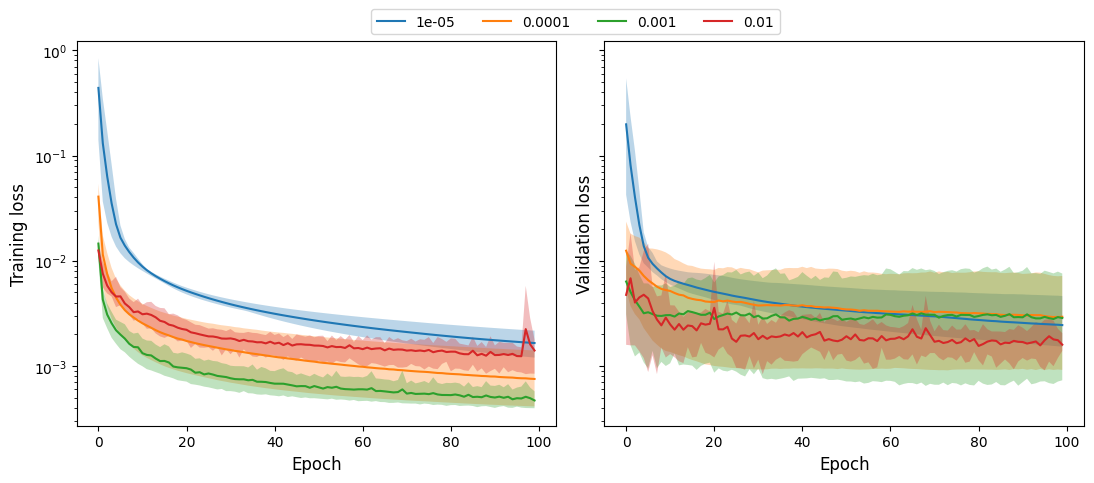

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 5), sharey=True)
for history_dict in history_arr:
    label = f'{history_dict["learning_rate"]}'
    mean_train_loss = np.mean([history['loss'] for history in history_dict['history']], axis=0)
    mean_val_loss = np.mean([history['val_loss'] for history in history_dict['history']], axis=0)
    max_train_loss = np.max([history['loss'] for history in history_dict['history']], axis=0)
    max_val_loss = np.max([history['val_loss'] for history in history_dict['history']], axis=0)
    min_train_loss = np.min([history['loss'] for history in history_dict['history']], axis=0)
    min_val_loss = np.min([history['val_loss'] for history in history_dict['history']], axis=0)
    ax[0].plot(mean_train_loss, label=label)
    ax[0].fill_between(range(len(mean_train_loss)), min_train_loss, max_train_loss, alpha=0.3)
    ax[1].plot(mean_val_loss, label=label)
    ax[1].fill_between(range(len(mean_val_loss)), min_val_loss, max_val_loss, alpha=0.3)
ax[0].set_xlabel('Epoch', fontsize=12)
ax[0].set_ylabel('Training loss', fontsize=12)
ax[1].set_xlabel('Epoch', fontsize=12)
ax[1].set_ylabel('Validation loss', fontsize=12)
ax[0].semilogy()
ax[1].semilogy()
ax[0].legend(bbox_to_anchor=(0.6, 1.1), ncols=4, loc='upper left')
fig.subplots_adjust(wspace=0.1)
plt.savefig('figures/conv_relu/autoencoder_lr_history.pdf', bbox_inches='tight')
plt.show()

In [5]:
# Print the difference between the training and validation loss
for history_dict in history_arr:
    mean_train_loss = np.mean([history['loss'] for history in history_dict['history']], axis=0)
    mean_val_loss = np.mean([history['val_loss'] for history in history_dict['history']], axis=0)
    print(f'Learning rate: {history_dict["learning_rate"]}, Difference: {mean_train_loss[-1] - mean_val_loss[-1]}')

Learning rate: 1e-05, Difference: -0.0007959041278809307
Learning rate: 0.0001, Difference: -0.0021859119238797574
Learning rate: 0.001, Difference: -0.0023893219709862027
Learning rate: 0.01, Difference: -0.0001913271378725769


In [38]:
with open('experiments/autoencoder_conv_history_batch.json', 'r') as f:
    history_arr = json.load(f)

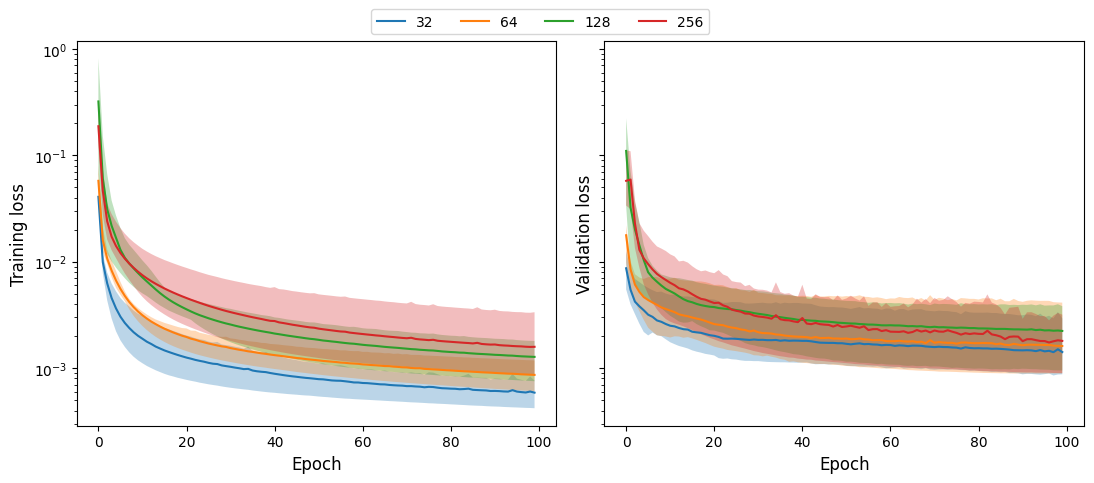

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 5), sharey=True)
for history_dict in history_arr:
    label = f'{history_dict["batch_size"]}'
    mean_train_loss = np.mean([history['loss'] for history in history_dict['history']], axis=0)
    mean_val_loss = np.mean([history['val_loss'] for history in history_dict['history']], axis=0)
    max_train_loss = np.max([history['loss'] for history in history_dict['history']], axis=0)
    max_val_loss = np.max([history['val_loss'] for history in history_dict['history']], axis=0)
    min_train_loss = np.min([history['loss'] for history in history_dict['history']], axis=0)
    min_val_loss = np.min([history['val_loss'] for history in history_dict['history']], axis=0)
    ax[0].plot(mean_train_loss, label=label)
    ax[0].fill_between(range(len(mean_train_loss)), min_train_loss, max_train_loss, alpha=0.3)
    ax[1].plot(mean_val_loss, label=label)
    ax[1].fill_between(range(len(mean_val_loss)), min_val_loss, max_val_loss, alpha=0.3)
ax[0].set_xlabel('Epoch', fontsize=12)
ax[0].set_ylabel('Training loss', fontsize=12)
ax[1].set_xlabel('Epoch', fontsize=12)
ax[1].set_ylabel('Validation loss', fontsize=12)
ax[0].semilogy()
ax[1].semilogy()
ax[0].legend(bbox_to_anchor=(0.6, 1.1), ncols=4, loc='upper left')
fig.subplots_adjust(wspace=0.1)
plt.savefig('figures/conv_relu/autoencoder_batch_history.pdf', bbox_inches='tight')
plt.show()

In [8]:
# Print the difference between mean training and validation loss
for history_dict in history_arr:
    mean_train_loss = np.mean([history['loss'] for history in history_dict['history']], axis=0)
    mean_val_loss = np.mean([history['val_loss'] for history in history_dict['history']], axis=0)
    print(f'Batch size: {history_dict["batch_size"]}, Difference: {mean_train_loss[-1] - mean_val_loss[-1]}')

Batch size: 32, Difference: -0.0008286018506623804
Batch size: 64, Difference: -0.0007513390039093793
Batch size: 128, Difference: -0.0009618095355108382
Batch size: 256, Difference: -0.0002170372405089437


#### 5. Train and save a model with optimal hyperparameters

In [23]:
optimizer = Adam(learning_rate=1e-5)
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

In [28]:
history = autoencoder.fit(
    X_train, X_train,
    epochs=500,
    batch_size=32,
    shuffle=False,
    validation_data=(X_val, X_val),
    callbacks=[early_stopping],
)

Epoch 1/500


I0000 00:00:1720608212.673267 2211790 service.cc:145] XLA service 0x7ff5c80303a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720608212.673291 2211790 service.cc:153]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2024-07-10 11:43:32.738276: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-10 11:43:33.112216: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  72/1816 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.7415  

I0000 00:00:1720608215.695952 2211790 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1816/1816 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.3545 - val_loss: 0.0733
Epoch 2/500
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0596 - val_loss: 0.0273
Epoch 3/500
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0270 - val_loss: 0.0133
Epoch 4/500
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0184 - val_loss: 0.0099
Epoch 5/500
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0143 - val_loss: 0.0082
Epoch 6/500
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0116 - val_loss: 0.0072
Epoch 7/500
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0098 - val_loss: 0.0065
Epoch 8/500
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0086 - val_loss: 0.0060
Epoch 9/500
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0078 - val_loss: 0.0056
Epoch 10/500
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0071 - val_loss: 0.0054
Epoch 11/500
1816/1816 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0066 - val_loss: 0.0051
Epoch 12/500
1816/1816 ━━━━━━━

In [29]:
autoencoder.save('models/autoencoder_conv_relu.keras')

#### 6. Evaluate model on test data 

In [4]:
from tensorflow.keras.models import load_model
autoencoder = load_model('models/autoencoder_conv_relu.keras')

2024-07-02 13:20:00.465317: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-02 13:20:00.492841: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-02 13:20:04.027899: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-07-02 13:20:10.816594: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/t

In [30]:
test_loss = autoencoder.evaluate(X_test, X_test)
print(f'Test loss: {test_loss}')

607/607 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.1936e-04 
Test loss: 0.0009610030683688819


In [31]:
y_pred = autoencoder.predict(X_test)
y_pred.shape

607/607 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


(19400, 600)

In [32]:
# Calculate the reconstruction error
reconstruction_error = np.mean(np.abs(y_pred - X_test), axis=1)
reconstruction_error.shape

(19400,)

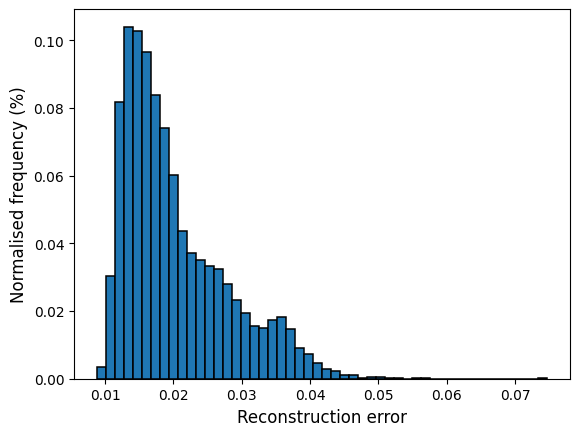

In [34]:
weights = np.ones_like(reconstruction_error) / float(len(reconstruction_error))

fig, ax = plt.subplots()
ax.hist(reconstruction_error, bins=50, weights=weights, edgecolor='black', linewidth=1.1)
ax.set_xlabel('Reconstruction error', fontsize=12)
ax.set_ylabel('Normalised frequency (%)', fontsize=12)
# plt.savefig('figures/autoencoder_reconstruction_error_relu.pdf', bbox_inches='tight')
plt.show()

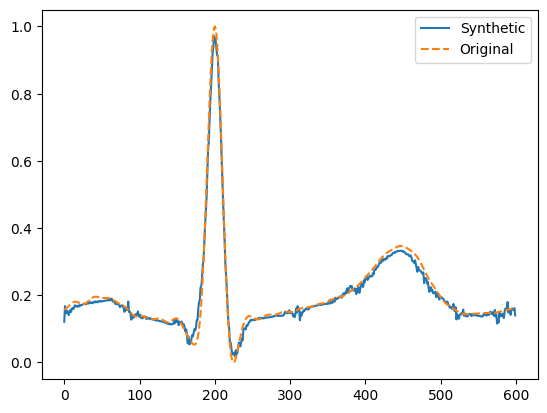

In [35]:
fig, ax = plt.subplots()
ax.plot(y_pred[-1], label='Synthetic')
ax.plot(X_test[-1], '--', label='Original')
ax.legend()
plt.show()